In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from collections import defaultdict

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
transform = transforms.Compose( [                                  
                                 transforms.Resize((224,224)),
                                 transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(),
                                  ])



trainset = ImageFolder('/content/drive/MyDrive/120-170-5/train', transform=transform)
testset = ImageFolder('/content/drive/MyDrive/120-170-5/test', transform=transform)

print('length of trainset :',len(trainset))
print('length of validation set :',len(testset))

length of trainset : 5323
length of validation set : 1331


In [4]:
train_loader = DataLoader(trainset, 16, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, 16, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 3, 224, 224]) torch.Size([16])


In [6]:
class_names = trainset.classes
print(class_names)

['demented', 'normal']


In [7]:
dataset_sizes={'val':len(testset),'train':len(trainset)}

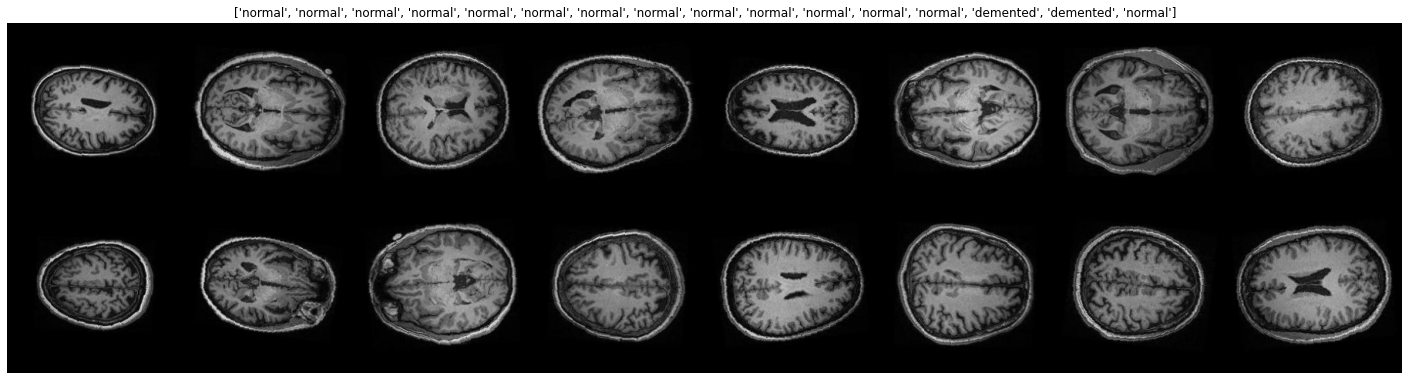

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(25, 25))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

show_databatch(inputs, classes)

In [9]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(test_loader):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training)

In [10]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(test_loader):
        if i % 10 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data).item()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['val']
    avg_acc = acc_test / dataset_sizes['val']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)


In [11]:
vgg19 = models.vgg19(pretrained=True)
print(vgg19.classifier[6].out_features)  


for param in vgg19.features.parameters():
    param.require_grad = False


num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
vgg19.classifier = nn.Sequential(*features)
print(vgg19)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [12]:
if use_gpu:
    vgg19.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(vgg19.parameters(), lr=1e-5, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [13]:
print("Test before training")
eval_model(vgg19, criterion)

Test before training
Evaluating model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test batch 0/84

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test batch 80/84
Evaluation completed in 2m 26s
Avg loss (test): 0.0383
Avg acc (test): 0.7521
----------


In [14]:
history = defaultdict(list)

In [15]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_loader)
    val_batches = len(test_loader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(train_loader):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            if i >= train_batches:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()

        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(test_loader):
            if i % 10 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data).item()

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes['val']
        avg_acc_val = acc_val / dataset_sizes['val']
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        history['epoch'].append(epoch+1)
        history['avg_loss'].append(round(avg_loss,5))
        history['avg_acc'].append(round(avg_acc,5))
        history['avg_loss_val'].append(round(avg_loss_val,5))
        history['avg_acc_val'].append(round(avg_acc_val,5))
    
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [16]:
def plot_results(history):
    avg_acc = history['avg_acc']
    avg_acc_val = history['avg_acc_val']
    avg_loss = history['avg_loss']
    avg_loss_val = history['avg_loss_val']
    epochs = history['epoch']

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, avg_acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, avg_acc_val, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')  
    
    plt.subplot(1,2,2)
    plt.plot(epochs, avg_loss, 'b', label = 'Training Loss')
    plt.plot(epochs, avg_loss_val, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

In [17]:
vgg19 = train_model(vgg19, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/50
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training batch 330/333
Validation batch 80/84
Epoch 0 result: 
Avg loss (train): 0.0326
Avg acc (train): 0.7588
Avg loss (val): 0.0289
Avg acc (val): 0.7919
----------

Epoch 1/50
----------
Training batch 330/333
Validation batch 80/84
Epoch 1 result: 
Avg loss (train): 0.0280
Avg acc (train): 0.7870
Avg loss (val): 0.0275
Avg acc (val): 0.8137
----------

Epoch 2/50
----------
Training batch 330/333
Validation batch 80/84
Epoch 2 result: 
Avg loss (train): 0.0258
Avg acc (train): 0.8082
Avg loss (val): 0.0272
Avg acc (val): 0.8182
----------

Epoch 3/50
----------
Training batch 330/333
Validation batch 80/84
Epoch 3 result: 
Avg loss (train): 0.0247
Avg acc (train): 0.8206
Avg loss (val): 0.0259
Avg acc (val): 0.8234
----------

Epoch 4/50
----------
Training batch 330/333
Validation batch 80/84
Epoch 4 result: 
Avg loss (train): 0.0236
Avg acc (train): 0.8255
Avg loss (val): 0.0300
Avg acc (val): 0.7754
----------

Epoch 5/50
----------
Training batch 330/333
Validation batch 80/84

In [18]:
eval_model(vgg19, criterion)

Evaluating model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test batch 80/84
Evaluation completed in 0m 23s
Avg loss (test): 0.0267
Avg acc (test): 0.8385
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Ground truth:


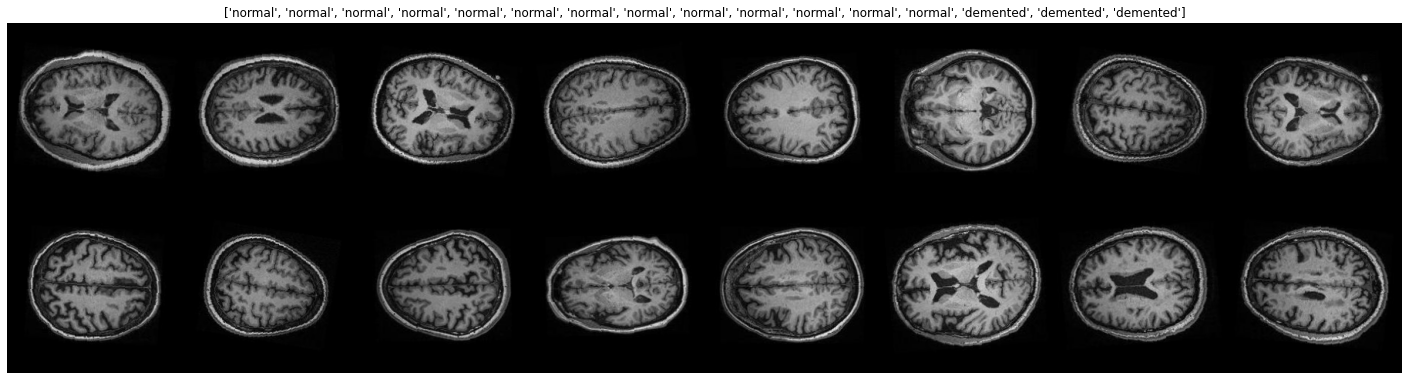

Prediction:


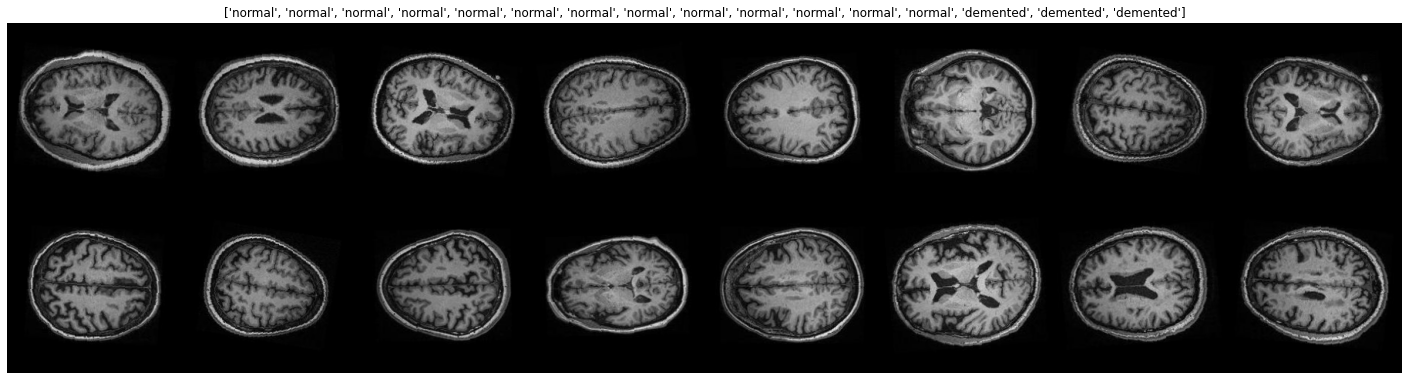

Ground truth:


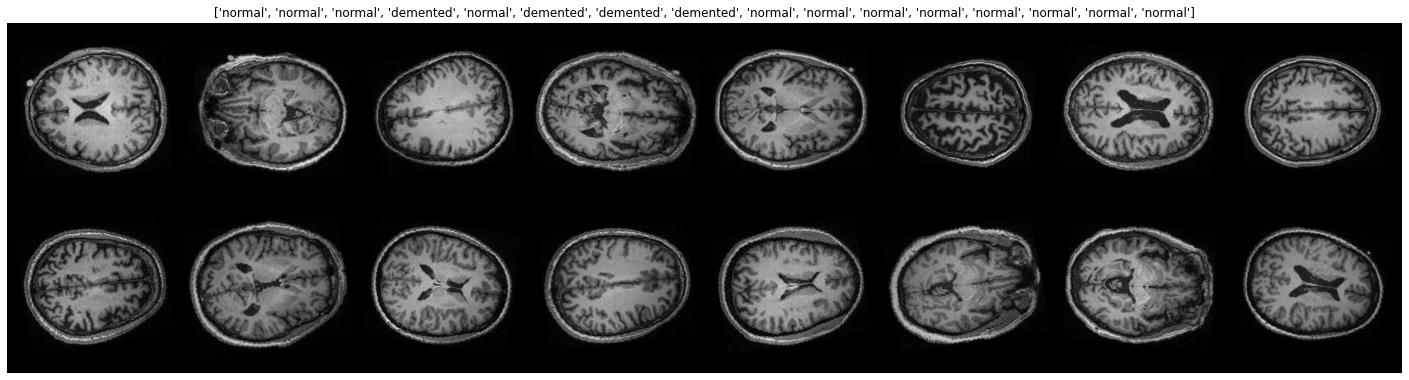

Prediction:


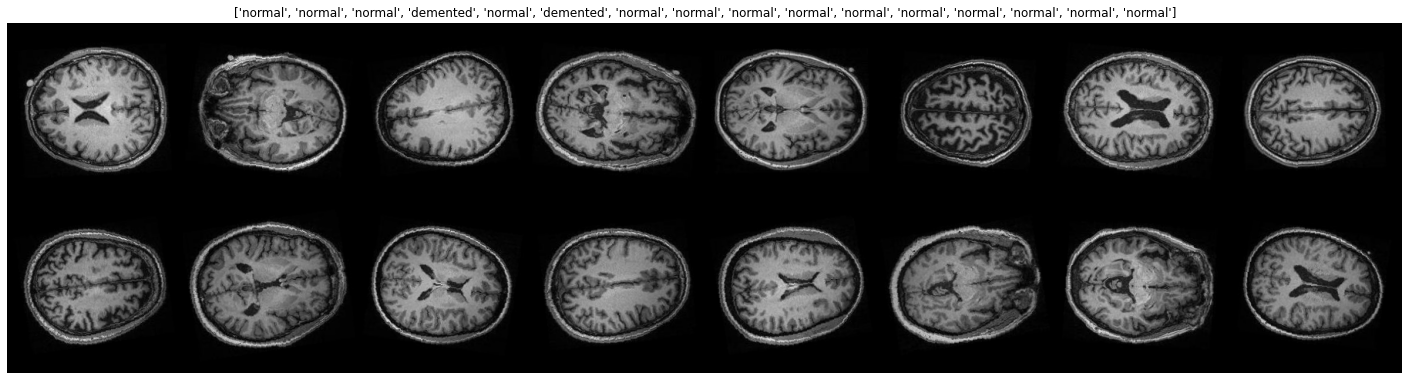

In [19]:
visualize_model(vgg19, num_images=32)

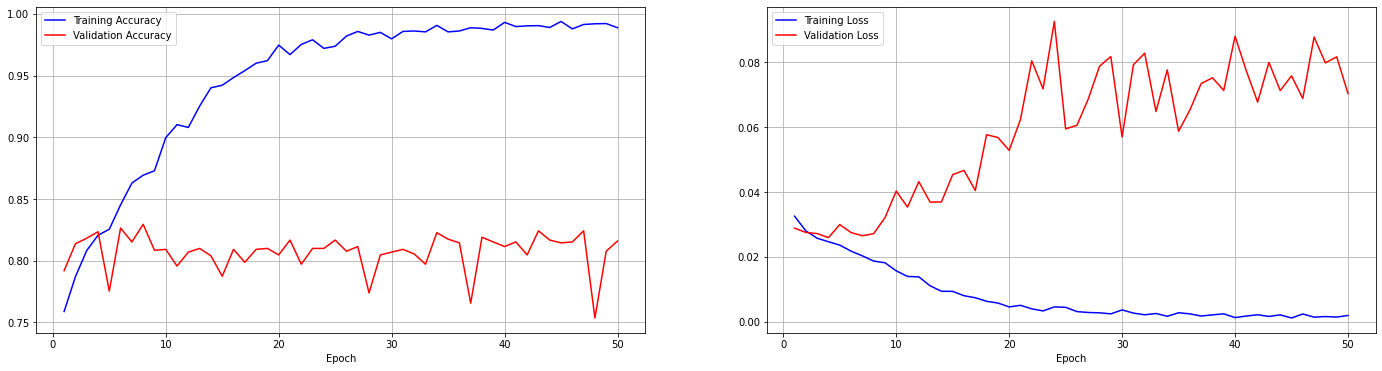

In [20]:
plot_results(history)